[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bulyn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


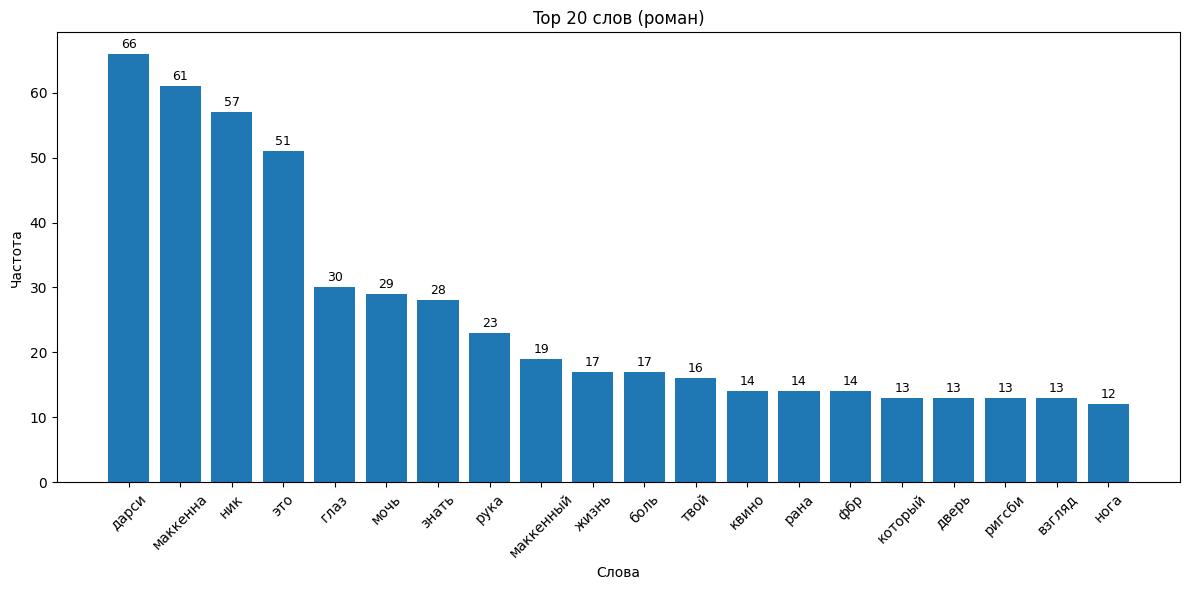

[роман] Математическое ожидание: 26.00, Среднеквадратичное отклонение: 17.41


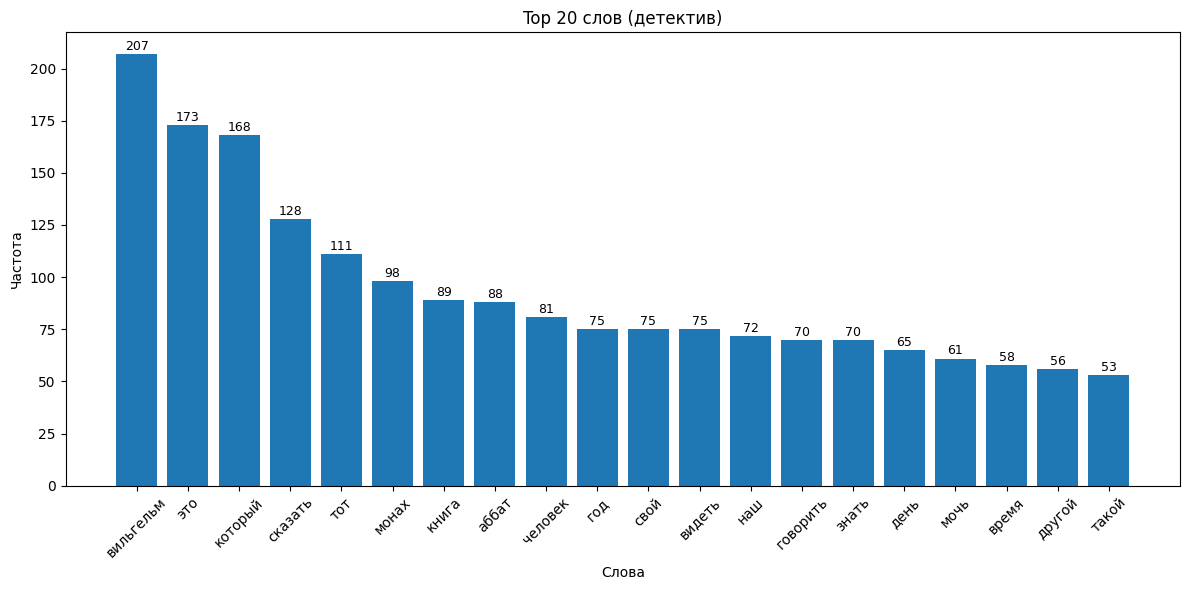

[детектив] Математическое ожидание: 93.65, Среднеквадратичное отклонение: 41.98


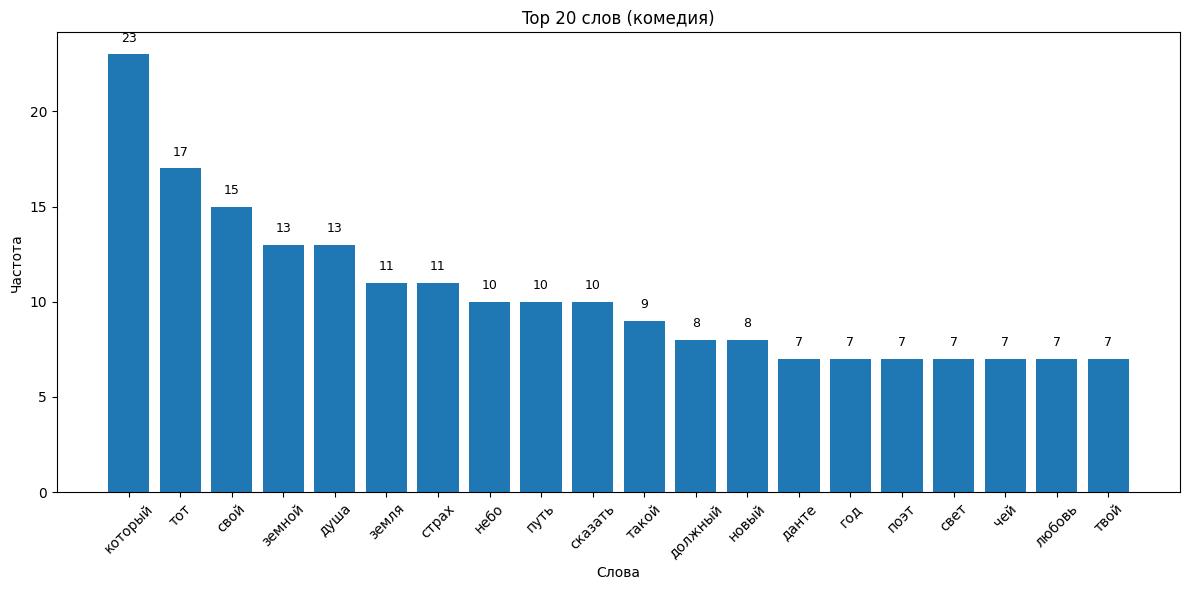

[комедия] Математическое ожидание: 10.35, Среднеквадратичное отклонение: 4.08
Общие ключевые слова в топ-20 всех жанров: {'который'}


In [4]:
from natasha import Segmenter, NewsEmbedding, NewsMorphTagger, MorphVocab, Doc
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import norm
import numpy as np
import nltk
import string
import os
import re

# Загрузка стоп-слов
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words("russian"))

# Инициализация компонентов Natasha
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
morph_vocab = MorphVocab()

EXTRA_SYMBOLS = '«»—–…“”’‘*•№→←'

def lemmatize_text(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation + EXTRA_SYMBOLS))
    text = re.sub(r'[^\w\s]', ' ', text)

    doc = Doc(text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)

    lemmas = []
    for token in doc.tokens:
        if not token.text.isalpha():
            continue
        if token.text in stop_words:
            continue
        token.lemmatize(morph_vocab)
        lemma = token.lemma
        if len(lemma) > 2:
            lemmas.append(lemma)

    return Counter(lemmas)

def plot_frequency(counter, N=20, title=""):
    common = counter.most_common(N)
    words, freqs = zip(*common)

    plt.figure(figsize=(12, 6))
    bars = plt.bar(words, freqs)
    plt.xticks(rotation=45)
    plt.title(f"Top {N} слов ({title})")
    plt.xlabel("Слова")
    plt.ylabel("Частота")

    for bar, freq in zip(bars, freqs):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(freq),
                 ha='center', va='bottom', fontsize=9)

    plt.tight_layout()
    plt.show()

    mu, std = norm.fit(freqs)
    print(f"[{title}] Математическое ожидание: {mu:.2f}, Среднеквадратичное отклонение: {std:.2f}")

    return set(words)


# Пути к файлам
files = {
    "роман": "roman.txt",
    "детектив": "detective.txt",
    "комедия": "comedy.txt"
}

results = {}
N = 15
try:
    N = int(input("Введите N (15-30): "))
    if N < 15 or N > 30:
        raise ValueError("N должно быть от 15 до 30")
except ValueError as e:
    print(f"Ошибка: {e}")
    exit()

for genre, filename in files.items():
    if not os.path.exists(filename):
        print(f"Файл не найден: {filename}")
        continue
    with open(filename, "r", encoding="utf-8") as f:
        text = f.read()
    counter = lemmatize_text(text)
    top_words = plot_frequency(counter, N=N, title=genre)
    results[genre] = top_words

# Пересечение лемм
if len(results) == 3:
    common_words = set.intersection(*results.values())
    if common_words:
        print(f"Общие ключевые слова в топ-{N} всех жанров: {common_words}")
    else:
        print("Общих слов не найдено.")
else:
    print("Не все тексты были обработаны.")
